# L4-D - Building your own Quantizer: Load your Quantized Weights from Hugging Face Hub

In this lesson, you will learn memory efficient model loading.

Run the next cell to import all of the functions you have used before in the previous lesson(s) of `Building your own Quantizer` to follow along with the video.

- To access the `helper.py` file, you can click `File --> Open...`, on the top left.

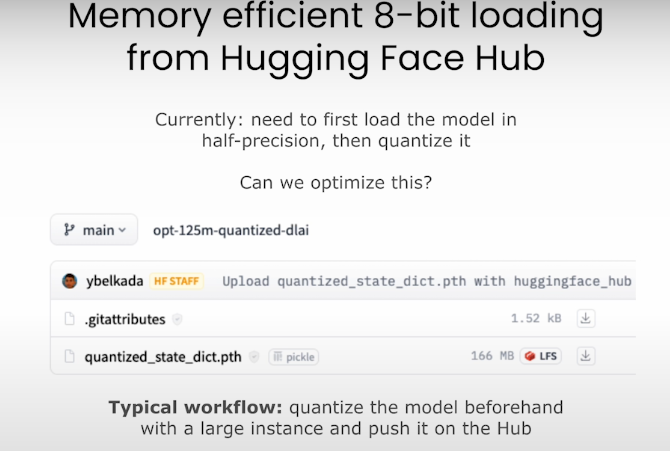

In [ ]:
import torch

from helper import W8A16LinearLayer, replace_linear_with_target_and_quantize, replace_linear_with_target

## Memory Efficient Model Loading

- Load [facebook/opt-125m](https://huggingface.co/facebook/opt-125m)

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model_id = "./models/facebook/opt-125m"

model = AutoModelForCausalLM.from_pretrained(
    model_id, torch_dtype=torch.bfloat16, low_cpu_mem_usage=True)
tokenizer = AutoTokenizer.from_pretrained(model_id)

In [ ]:
replace_linear_with_target_and_quantize(model, 
                             W8A16LinearLayer, 
                                   ["lm_head"])

In [ ]:
model

In [ ]:
quantized_state_dict = model.state_dict()
torch.save(quantized_state_dict, "quantized_state_dict.pth")

- The below code is for demonstration purposes only.
- You'll need your own Hugging Face username in order for it to run.
- You'll add your usernmae in `YOUR_HF_USERNAME = ""` 

```Python
from huggingface_hub import HfApi, create_repo

YOUR_HF_USERNAME = ""
your_repo_id = f"{YOUR_HF_USERNAME}/opt-125m-quantized-dlai"

api = HfApi()

# create_repo(your_repo_id)

api.upload_file(
 path_or_fileobj="quantized_state_dict.pth",
 path_in_repo="quantized_state_dict.pth",
 repo_id=your_repo_id
)
```

### Load the Model in the Meta Device

In [ ]:
from transformers import OPTForCausalLM, AutoTokenizer, AutoConfig

model_id = "./models/facebook/opt-125m"
config = AutoConfig.from_pretrained(model_id)

with torch.device("meta"):
  model = OPTForCausalLM(config)

tokenizer = AutoTokenizer.from_pretrained(model_id)

In [ ]:
for param in model.parameters():
  print(param)

In [ ]:
model

In [ ]:
replace_linear_with_target(model, W8A16LinearLayer, ["lm_head"])

In [ ]:
model

In [ ]:
from huggingface_hub import hf_hub_download

state_dict_cache_path = hf_hub_download(
    "ybelkada/opt-125m-quantized-dlai",
    "quantized_state_dict.pth"
)

In [ ]:
state_dict = torch.load(state_dict_cache_path)

In [ ]:
model.load_state_dict(state_dict, strict=True, assign=True)

- Test your model.
- **Note:** Your generated text might be different than what you see in the video.

In [ ]:
from transformers import pipeline

pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)
pipe("Hello today I am", max_new_tokens=40)

In [ ]:
pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)
pipe("Hello today I am giving a course about", max_new_tokens=10)